In [1]:
import pandas as pd
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [2]:
from matplotlib import rc

labelsize = 6
linewidth = 0.6
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth-0.2)
rc('ytick.minor', width=linewidth-0.2)
rc('patch', linewidth=linewidth)

major_type_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
sub_region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()


In [3]:
oddsratio_cutoff = 1.8
lgp_cutoff = 15

## Layer and region results

In [4]:
layer_results = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ITSpatial/DMRAnalysis/AggLayerDMR/LayerDMR.one_motif_per_class.msg'
)

region_results = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ITSpatial/DMRAnalysis/RegionSpecificDMR/RegionDMR.one_motif_per_class.msg'
)

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Select motif class

In [5]:
motif_class_order = [
    # 'More than 3 adjacent zinc fingers',
    'MyoD-ASC-related',
    'RFX',
    'POU',
    'PD+HD',
    'Paired-related HD',
    'HOX',
    'HD-LIM',
    'NK',
    # 'DMRT',
    'Thyroid hormone receptor-related factors',
    'Regulators of differentiation',
    'bHLH-ZIP',
    'Tal-related',
    'SMAD',
    'Jun-related',
    'Fos-related',
    'B-ATF-related',
    'CEBP-related',
]

layer_order = ['IT-L23', 'IT-L4', 'IT-L5', 'IT-L6']

region_order = [
    'IT-L23+ORB', 'IT-L23+PFC', 'IT-L23+ACA', 'IT-L23+AI', 'IT-L23+MOs',
    'IT-L23+MOp', 'IT-L23+SSp', 'IT-L23+SSs'
]

## Prepare plot tidy data

### Layer

In [6]:
layer_results = layer_results[layer_results['motif_class'].isin(motif_class_order)].copy()

layer_results['sig'] = (layer_results['-lgp'] > lgp_cutoff) & (layer_results['oddsratio'] > oddsratio_cutoff)
layer_results['x'] = layer_results['motif_class'].apply(lambda i: motif_class_order.index(i))
layer_results['y'] = layer_results['Group'].apply(lambda i: layer_order.index(i))


In [7]:
layer_dmr_counts = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/study/ITSpatial/DMRAnalysis/AggLayerDMR/LayerDMR.counts.csv'
)

### Region

In [8]:
region_results = region_results[region_results['motif_class'].isin(motif_class_order) & 
                                region_results['Group'].str.startswith('IT-L23')].copy()
region_results['sig'] = (region_results['-lgp'] > lgp_cutoff) & (region_results['oddsratio'] > oddsratio_cutoff)

region_results['x'] = region_results['motif_class'].apply(lambda i: motif_class_order.index(i))
region_results['y'] = region_results['Group'].apply(lambda i: region_order.index(i))


In [9]:
region_dmr_counts = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/study/ITSpatial/DMRAnalysis/RegionSpecificDMR/RegionDMR.counts.csv'
)

## Plot

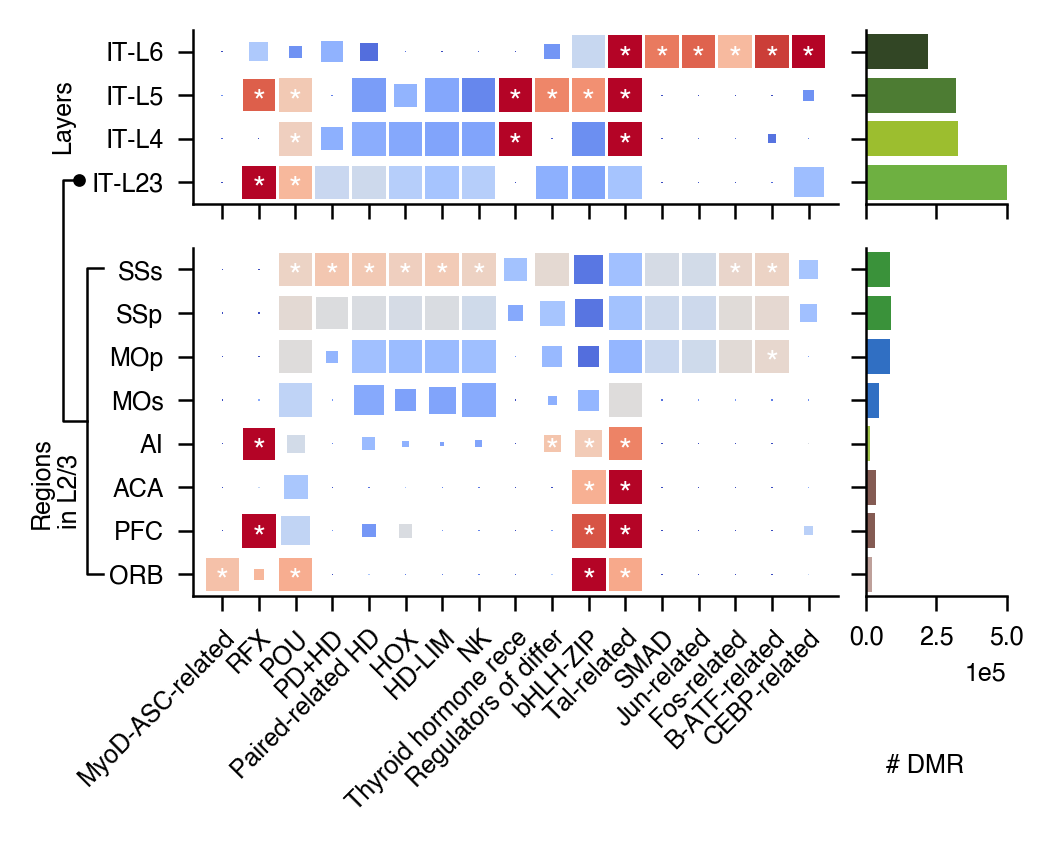

In [10]:
fig = plt.figure(figsize=(3.5, 2.5), dpi=300)
gs = fig.add_gridspec(13, 10, wspace=0.5, hspace=0)

ax_layer_main = fig.add_subplot(gs[:4, :-2])
ax_layer_bar = fig.add_subplot(gs[:4, -2:])

ax_region_main = fig.add_subplot(gs[5:, :-2])
ax_region_bar = fig.add_subplot(gs[5:, -2:])

ax_all = fig.add_subplot(gs[:, :])
sns.despine(ax=ax_all, left=True, bottom=True)
ax_all.set(xticks=[], yticks=[])
ax_all.patch.set_alpha(0)


# layer specific DMR motif enrichment
ax = ax_layer_main
sns.scatterplot(ax=ax, data=layer_results, x='x', y='y', 
                hue='oddsratio', hue_norm=(1, 2.5), palette='coolwarm', marker='s',
                size='-lgp', size_norm=(10, 50), sizes=(0.1, 65), 
                linewidth=0, clip_on=False)

for _, row in layer_results[layer_results['sig']].iterrows():
    ax.text(row['x'], row['y']-0.2, '*', ha='center', va='center', 
            fontsize=labelsize+2, c='white')

ax.set(xticks=range(len(motif_class_order)), 
       ylim=(-0.5, 3.5), yticklabels=layer_order, yticks=[0, 1, 2, 3],
       xticklabels=[], xlabel='', ylabel='Layers')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
sns.despine(ax=ax)
ax.legend_.set_visible(False)


# layer specific DMR counts
ax = ax_layer_bar
sns.barplot(ax=ax, data=layer_dmr_counts, x='# DMR', y='Layer', palette=major_type_palette,
            order=layer_order[::-1])
ax.set(xlim=(0, 500000), yticklabels=[], xticks=[0, 250000, 500000], xticklabels=[], ylabel='', xlabel='')
sns.despine(ax=ax)


# region specific DMR motif enrichment in L23
ax = ax_region_main
n = len(region_order)
sns.scatterplot(ax=ax, data=region_results, x='x', y='y', 
                hue='oddsratio', hue_norm=(1, 2.5), palette='coolwarm', marker='s',
                size='-lgp', size_norm=(10, 50), sizes=(0.1, 65), 
                linewidth=0, clip_on=False)

for _, row in region_results[region_results['sig']].iterrows():
    ax.text(row['x'], row['y']-0.2, '*', ha='center', va='center', 
            fontsize=labelsize+2, c='white')

ax.set(xticks=range(len(motif_class_order)), 
       ylim=(-0.5, n-0.5), yticks=list(range(n)),
       xticklabels=[i[:20] for i in motif_class_order], 
       yticklabels=[i.split('+')[1] for i in region_order],
       xlabel='', ylabel='')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
sns.despine(ax=ax)
ax.legend_.set_visible(False)

# region specific DMR counts in L23
ax = ax_region_bar
group_palette = {g: sub_region_palette[g.split('+')[1]] for g in region_order}
sns.barplot(ax=ax, data=region_dmr_counts, x='# DMR', y='Group', palette=group_palette,
            order=region_order[::-1])
ax.set(xlim=(0, 500000), yticklabels=[], xticks=[0, 250000, 500000], ylabel='', xlabel='')
ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
sns.despine(ax=ax)

# add an outer bracket
ax = ax_all
ax.plot((-0.11, -0.13, -0.13, -0.11), 
        (0.04, 0.04, 0.58, 0.58), c='k',
        transform=ax.transAxes, clip_on=False)
ax.plot((-0.14, -0.16, -0.16, -0.13), 
        (0.735, 0.735, 0.31, 0.31), c='k',
        transform=ax.transAxes, clip_on=False)
ax.scatter(-0.14, 0.735, s=6, c='k',
        transform=ax.transAxes, clip_on=False)
ax.text(-0.2, 0.2, 'Regions\nin L2/3', rotation=90,
        fontsize=labelsize,
        va='center', ha='left',
        transform=ax.transAxes, clip_on=False)
ax.text(0.9, -0.3, '# DMR',
        fontsize=labelsize,
        va='center', ha='center',
        transform=ax.transAxes, clip_on=False)
# ax.text(1.03, 0.95, 'Layer\nDMR',
#         fontsize=labelsize-1,
#         va='center', ha='right',
#         transform=ax.transAxes, clip_on=False, zorder=100)
# ax.text(1, 0.58, 'Region DMR\nwithin L2/3',
#         fontsize=labelsize-1,
#         va='center', ha='right',
#         transform=ax.transAxes, clip_on=False)

fig.savefig(f'LayerAndRegionSpecificDMR.heatmap.pdf', bbox_inches='tight')

In [11]:
region_dmr_counts[region_dmr_counts['Layer'] == 'IT-L23']

,Group,# DMR,Layer,Region
12,IT-L23+ACA,35038,IT-L23,ACA
13,IT-L23+AI,13423,IT-L23,AI
14,IT-L23+MOp,84013,IT-L23,MOp
15,IT-L23+ORB,19402,IT-L23,ORB
16,IT-L23+PFC,32823,IT-L23,PFC
17,IT-L23+SSp,89138,IT-L23,SSp
18,IT-L23+MOs,46287,IT-L23,MOs
19,IT-L23+SSs,83210,IT-L23,SSs
